# UCLA Electrical and Computer Engineering: Heart Disease Classification Project

## Import Necessary Libraries and Given Helper Functions

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib
import os
import time

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder 

from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer



from matplotlib import pyplot
import itertools

%matplotlib inline

In [2]:
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.YlOrBr)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [3]:
def heatmap(data, row_labels, col_labels, figsize = (20,12), cmap = "YlGn",
            cbar_kw={}, cbarlabel="", valfmt="{x:.2f}",
        textcolors=("black", "white"), threshold=None):
    """
    Create a heatmap from a numpy array and two lists of labels. 
    
    Taken from matplotlib example.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cmap
        A string that specifies the colormap to use. Look at matplotlib docs for information.
        Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
    """

    plt.figure(figsize = figsize)
    ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data,cmap=cmap)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    
    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)


In [4]:
def make_meshgrid(x, y, h=0.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

def draw_contour(x,y,clf, class_labels = ["Negative", "Positive"]):
    """
    Draws a contour line for the predictor
    
    Assumption that x has only two features. This functions only plots the first two columns of x.
    
    """
    
    X0, X1 = x[:, 0], x[:, 1]
    xx0, xx1 = make_meshgrid(X0,X1)
    
    plt.figure(figsize = (10,6))
    plot_contours(clf, xx0, xx1, cmap="PiYG", alpha=0.8)
    scatter=plt.scatter(X0, X1, c=y, cmap="PiYG", s=30, edgecolors="k")
    plt.legend(handles=scatter.legend_elements()[0], labels=class_labels)

    plt.xlim(xx0.min(), xx0.max())
    plt.ylim(xx1.min(), xx1.max())

## Visualizing Data and Initial Processing 

In [5]:
data = pd.read_csv('datasets/heartdisease.csv')

In [6]:
data.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,False
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,False
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,False
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,False
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,False


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'cp'}>,
        <Axes: title={'center': 'trestbps'}>],
       [<Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'fbs'}>,
        <Axes: title={'center': 'restecg'}>,
        <Axes: title={'center': 'thalach'}>],
       [<Axes: title={'center': 'exang'}>,
        <Axes: title={'center': 'oldpeak'}>,
        <Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'ca'}>],
       [<Axes: title={'center': 'thal'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

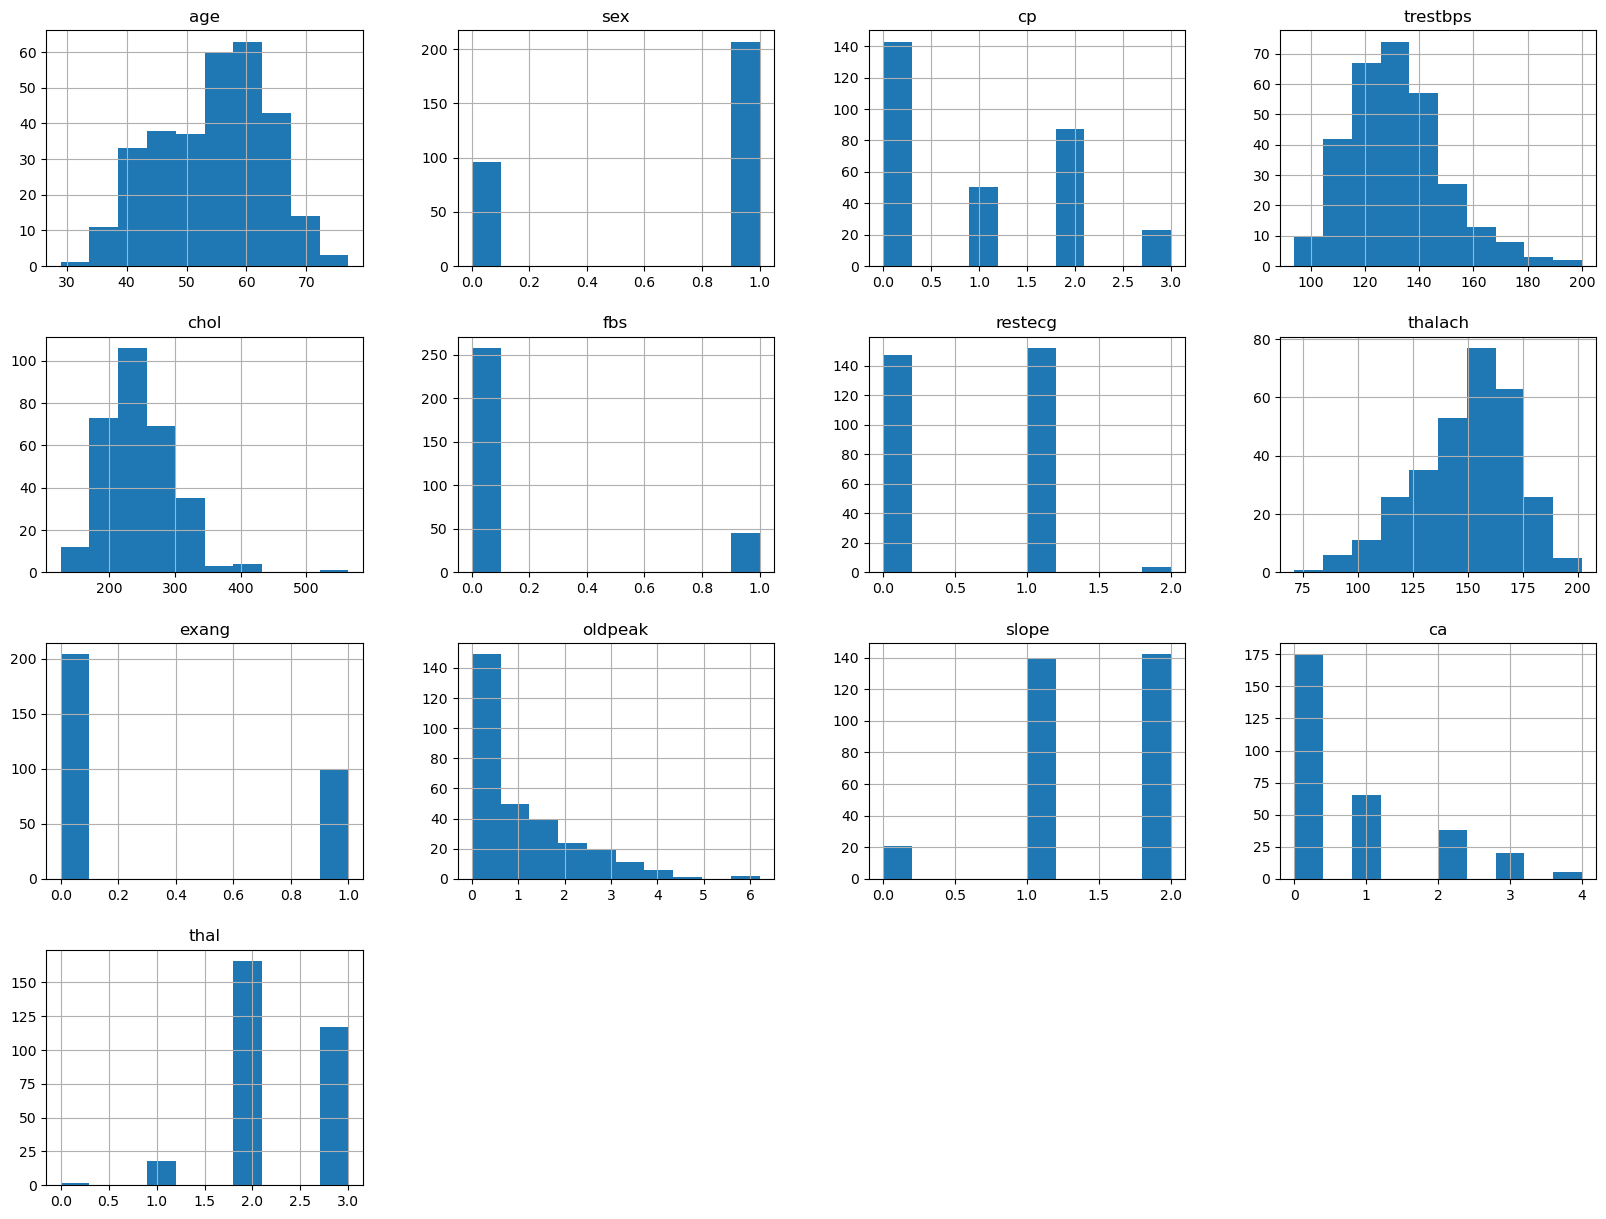

In [7]:
data.hist(figsize = (20,15))

### Initial Dataset Analysis

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  sick      303 non-null    bool   
dtypes: bool(1), float64(1), int64(12)
memory usage: 31.2 KB


Our target variable, sick, is of type bool and needs to be label encoded prior to modeling.

In [9]:
le = LabelEncoder() 
data['target'] = le.fit_transform(data['sick'])
data = data.drop(["sick"],axis= 1)

In [10]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

We are not dealing with any null values. Therefore, there is no need for imputation.

Healthy: 165 
Sick: 138 
Total: 303


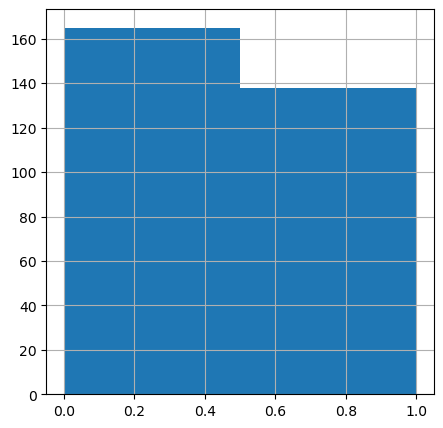

In [11]:
data['target'].hist(bins=2, figsize=(5,5))
count=data['target'].value_counts()
print("Healthy:",count[0],"\nSick:",count[1],"\nTotal:",count.sum())

Since label encoding transformed false to 0 sick and sick to 1, then our data set has 165 healthy individuals and 138 sick individuals. We see that 54.5% of the individuals in the dataset are healthy and 45.5% of the individuals in the dataset are sick. This dataset is sufficiently balanced since the percentages of both classes in the dataset are similar. Thus, we can ensure that the classifiers will train adequately and won't overfit

## Prepare Data for Use in Models

In [12]:
y=data["target"]
x=data.drop("target",axis=1)
full_pipeline=ColumnTransformer([
    ("num",StandardScaler(),["age","trestbps","chol","thalach","oldpeak"]),
    ("cat",OneHotEncoder(),['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca','thal'])])

train_raw, test_raw, target, target_test = train_test_split(x,y, test_size=0.4, stratify= y, random_state=0)

train = full_pipeline.fit_transform(train_raw)
test = full_pipeline.transform(test_raw)

Healthy: 99 
Sick: 82 
Total: 181


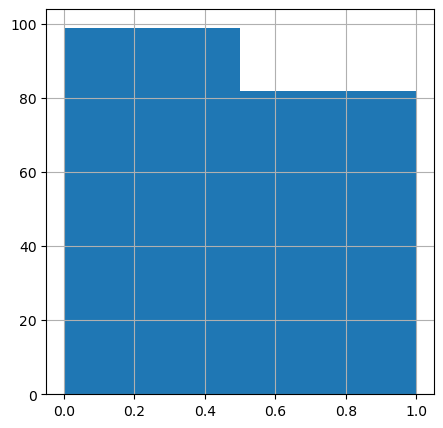

In [13]:
#Check for artificial class inbalance
target.hist(bins=2, figsize=(5,5))
target_count=target.value_counts()
print("Healthy:",target_count[0],"\nSick:",target_count[1],"\nTotal:",target_count.sum())

Healthy: 66 
Sick: 56 
Total: 122


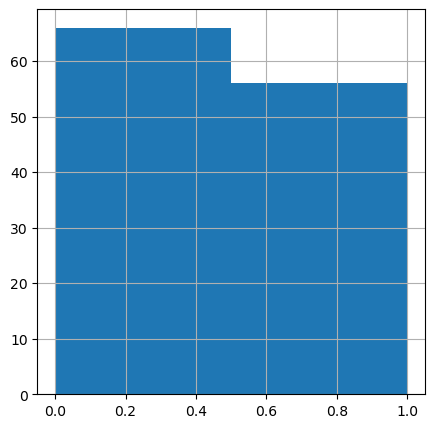

In [14]:
target_test.hist(bins=2, figsize=(5,5))
target_test_count=target_test.value_counts()
print("Healthy:",target_test_count[0],"\nSick:",target_test_count[1],"\nTotal:",target_test_count.sum())

Our test data set has 66 healthy individuals and 56 sick individuals. We see that 54.1% of the individuals in the dataset are healthy and 45.9% of the individuals in the dataset are sick. This is similar to the distribution of the whole data set with 54.5% healthy individuals and 45.5% sick individuals and to the distribution of the test data set with 54.7% healthy individuals and 45.3% sick individuals. There is no artificial class imbalance.

## Cross Validation and Model Selection

In [15]:
parameters = [
    {"n_neighbors": [1,3,5,7],
    "metric": ["euclidean","manhattan"]}, 
    {"penalty": ["l1","l2"],
    "solver": ["liblinear"],
    "C":[0.0001,0.1,10]},
    {"kernel": ["linear","rbf"],
    "C":[0.0001,0.1,10]}
]

knn=KNeighborsClassifier()
log_reg=LogisticRegression()
svm=SVC()
classifiers = [knn,log_reg, svm]
kf = KFold(n_splits=3, random_state=None)

res = pd.DataFrame()
clsf_list=[]
for i in range(0,3):
    grid = GridSearchCV(classifiers[i], parameters[i], cv = kf, scoring = "accuracy")
    grid.fit(train,target)
    temp=pd.DataFrame(grid.cv_results_)
    res=pd.concat([res,temp], ignore_index=True)
    
    #add column with classification type
    if classifiers[i]==knn:
        clsf= "KNN Classification"
    elif classifiers[i]==log_reg:
        clsf= "Logistic Regression"
    else:
        clsf= "Support Vector Machines (SVM)"
        
    for j in range(0,len(temp)):
        clsf_list.append(clsf)
        
res["classification_type"]=clsf_list

# compute new rankings with all three models in data frame
res['rank_test_score'] = res['mean_test_score'].rank(method='dense', ascending=False)
res["rank_test_score"]=res['rank_test_score'].astype(int)
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,param_C,param_penalty,param_solver,param_kernel,classification_type
0,0.002086,0.001488,0.028467,0.026840,euclidean,1,"{'metric': 'euclidean', 'n_neighbors': 1}",0.737705,0.783333,0.783333,0.768124,0.021509,14,NaN,NaN,NaN,NaN,KNN Classification
1,0.001115,0.000302,0.015848,0.002364,euclidean,3,"{'metric': 'euclidean', 'n_neighbors': 3}",0.803279,0.783333,0.900000,0.828871,0.050951,6,NaN,NaN,NaN,NaN,KNN Classification
2,0.001993,0.000815,0.038800,0.015392,euclidean,5,"{'metric': 'euclidean', 'n_neighbors': 5}",0.770492,0.833333,0.883333,0.829053,0.046167,4,NaN,NaN,NaN,NaN,KNN Classification
3,0.001192,0.000249,0.016920,0.002829,euclidean,7,"{'metric': 'euclidean', 'n_neighbors': 7}",0.754098,0.800000,0.883333,0.812477,0.053493,10,NaN,NaN,NaN,NaN,KNN Classification
4,0.001194,0.000234,0.012434,0.001954,manhattan,1,"{'metric': 'manhattan', 'n_neighbors': 1}",0.737705,0.750000,0.800000,0.762568,0.026940,15,NaN,NaN,NaN,NaN,KNN Classification
5,0.003103,0.000088,0.021478,0.002713,manhattan,3,"{'metric': 'manhattan', 'n_neighbors': 3}",0.803279,0.800000,0.883333,0.828871,0.038534,6,NaN,NaN,NaN,NaN,KNN Classification
6,0.001673,0.000979,0.014019,0.004531,manhattan,5,"{'metric': 'manhattan', 'n_neighbors': 5}",0.786885,0.833333,0.866667,0.828962,0.032717,5,NaN,NaN,NaN,NaN,KNN Classification
7,0.002104,0.001666,0.015476,0.001775,manhattan,7,"{'metric': 'manhattan', 'n_neighbors': 7}",0.770492,0.833333,0.866667,0.823497,0.039874,7,NaN,NaN,NaN,NaN,KNN Classification
8,0.001785,0.000267,0.000913,0.000097,NaN,NaN,"{'C': 0.0001, 'penalty': 'l1', 'solver': 'libl...",0.459016,0.566667,0.616667,0.547450,0.065779,17,0.0001,l1,liblinear,NaN,Logistic Regression
9,0.002719,0.001038,0.001585,0.000841,NaN,NaN,"{'C': 0.0001, 'penalty': 'l2', 'solver': 'libl...",0.721311,0.783333,0.833333,0.779326,0.045820,12,0.0001,l2,liblinear,NaN,Logistic Regression


In [16]:
maxValueIndex = res['rank_test_score'].idxmin()
best= res.loc[maxValueIndex]    
print("The best model is",best["classification_type"],"with parameters",best["params"],"and it's mean score is",best["mean_test_score"])

The best model is Support Vector Machines (SVM) with parameters {'C': 0.1, 'kernel': 'linear'} and it's mean score is 0.8620218579234972


The accuracy of the best model according to a GridSearchCV is 0.811475


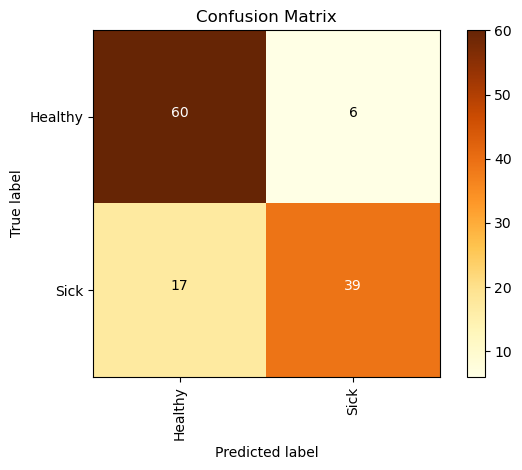

In [17]:
svm = SVC(kernel='linear', C=0.1)
svm.fit(train, target)
predicted = svm.predict(test)

print("%-12s %f" % ('The accuracy of the best model according to a GridSearchCV is', metrics.accuracy_score(target_test,predicted)))
draw_confusion_matrix(target_test, predicted, ['Healthy', 'Sick'])